In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
dtypes = {'fips': str}
covid_raw_df = pd.read_csv('us-counties.csv', dtype=dtypes, parse_dates=['date'])
covid_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502832 entries, 0 to 2502831
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   date    datetime64[ns]
 1   county  object        
 2   state   object        
 3   fips    object        
 4   cases   int64         
 5   deaths  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 114.6+ MB


In [3]:
# number of null values
covid_raw_df.isnull().sum()

date          0
county        0
state         0
fips      23678
cases         0
deaths    57605
dtype: int64

In [4]:
# show null values where fips is null, grouped by county and state
null_fips_df = covid_raw_df[covid_raw_df['fips'].isnull()].groupby(['county', 'state'])
null_fips_df.head()

,date,county,state,fips,cases,deaths
416,2020-03-01,New York City,New York,NaN,1,0.0
418,2020-03-01,Unknown,Rhode Island,NaN,2,0.0
448,2020-03-02,New York City,New York,NaN,1,0.0
450,2020-03-02,Unknown,Rhode Island,NaN,2,0.0
482,2020-03-03,New York City,New York,NaN,2,0.0
...,...,...,...,...,...,...
2121739,2022-01-16,Unknown,Texas,NaN,5754,0.0
2124991,2022-01-17,Unknown,Texas,NaN,11225,0.0
2128243,2022-01-18,Unknown,Texas,NaN,5997,0.0
2160186,2022-01-28,Unknown,Oregon,NaN,1,0.0


In [5]:
covid_raw_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0.0
1,2020-01-22,Snohomish,Washington,53061,1,0.0
2,2020-01-23,Snohomish,Washington,53061,1,0.0
3,2020-01-24,Cook,Illinois,17031,1,0.0
4,2020-01-24,Snohomish,Washington,53061,1,0.0


In [6]:
# load the cfips data
dtypes = {'cfips': str}
cfips_df = pd.read_csv('cfips.csv', dtype=dtypes)
cfips_df.head()

,cfips
0,01001
1,01003
2,01005
3,01007
4,01009


In [7]:
# get data for a Autauga county
autauga_df = covid_raw_df[covid_raw_df['fips'] == '01001']

In [8]:
autauga_df.head()

,date,county,state,fips,cases,deaths
9480,2020-03-24,Autauga,Alabama,01001,1,0.0
10835,2020-03-25,Autauga,Alabama,01001,4,0.0
12367,2020-03-26,Autauga,Alabama,01001,6,0.0
14025,2020-03-27,Autauga,Alabama,01001,6,0.0
15803,2020-03-28,Autauga,Alabama,01001,6,0.0


In [9]:
def get_monthly_data(df, cfips):
    # get the monthly data
    county_df = df[df['fips'] == cfips]
    monthly_df = county_df.groupby(pd.Grouper(key='date', freq='M')).sum()
    monthly_df.reset_index(inplace=True)
    monthly_df['date'] = monthly_df['date'].dt.strftime('%Y-%m')
    # get ridd of last row
    monthly_df = monthly_df[:-1]
    # get rid of the cases column
    monthly_df.drop(columns=['cases'], inplace=True)
    return monthly_df

      date  deaths
0  2020-03     0.0
1  2020-04   107.0
2  2020-05   335.0
3  2020-06   596.0
4  2020-07   990.0


<AxesSubplot:xlabel='date'>

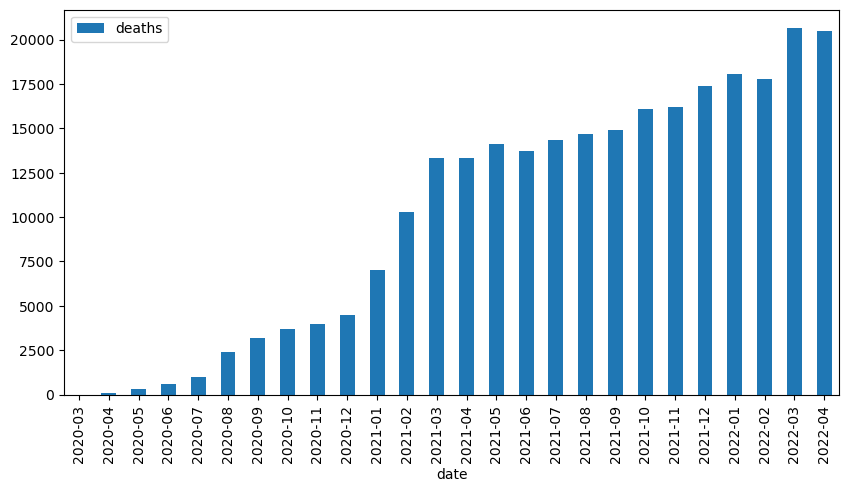

In [10]:
# same thing for santa barbara county
santa_barbara_monthly_df = get_monthly_data(covid_raw_df, '06083')
print(santa_barbara_monthly_df.head())
santa_barbara_monthly_df.plot(x='date', y=['deaths'], kind='bar', figsize=(10, 5))

## Assumming people stoped caring about covid from 2021-07

In [11]:
np.random.seed(0)

# random set of 30 counties's fips
fips = cfips_df.sample(30)['cfips'].values
print(fips)

growth_rate = []
decay_rate = []

for cfips in fips:
    county_df = get_monthly_data(covid_raw_df, cfips)
    county_df = county_df[-10:]
    diff = (county_df['deaths'].iloc[-1] / county_df['deaths'].iloc[0])**(0.1)
    growth_rate.append(diff)
    
mean_growth_rate = np.mean(growth_rate)
print(mean_growth_rate)

['29017' '27101' '08091' '42081' '38079' '45017' '48469' '17137' '47123'
 '55039' '26017' '40115' '35017' '13101' '17087' '48439' '27115' '20051'
 '48215' '22053' '26085' '18165' '48103' '12121' '01021' '26065' '48083'
 '38089' '37107' '26107']
1.0584289291216746


# For the missing months, impute by the mean of adjacent months
# For previous to March 2020, impute with 0
# For later than April 2022, impute with a decaying geometric series

In [12]:
GROWTH_RATE = 0.0584289291216746
DECAY_RATE = -0.00584289291216746 / 1.8

def impute_future_month(county_monthly_df, growth_rate=GROWTH_RATE, decay_rate=DECAY_RATE, more_months=20):
    ending_date = '2023-05'
    last_month = county_monthly_df.iloc[-1]
    last_month_date = last_month['date']
    for num_more in range(more_months):
        last_month_deaths = last_month['deaths']
        next_month_death = int(last_month_deaths * max(1,(1 + growth_rate + num_more * decay_rate)))
        next_month_date = pd.to_datetime(last_month_date) + pd.DateOffset(months=1)
        next_month_date = next_month_date.strftime('%Y-%m')
        next_month = pd.Series({'date': next_month_date, 'deaths': next_month_death})
        county_monthly_df = county_monthly_df.append(next_month, ignore_index=True)
        last_month = next_month
        last_month_date = next_month_date
        if next_month_date == ending_date:
            break
    return county_monthly_df

def impute_past_month(county_monthly_df, more_months=20):
    beginning_date = '2019-07'
    # impute past months with 0 deaths
    first_month = county_monthly_df.iloc[0]
    first_month_date = first_month['date']
    for num_more in range(more_months):
        prev_month_date = pd.to_datetime(first_month_date) - pd.DateOffset(months=1)
        prev_month_date = prev_month_date.strftime('%Y-%m')
        prev_month = pd.Series({'date': prev_month_date, 'deaths': 0})
        county_monthly_df = county_monthly_df.append(prev_month, ignore_index=True)
        first_month = prev_month
        first_month_date = prev_month_date
        if prev_month_date == beginning_date:
            break
    return county_monthly_df

def impute_missing_months(county_monthly_df):
    beginning_date = '2019-07'
    ending_date = '2023-05'
    month_list = pd.date_range(start=beginning_date, end=ending_date, freq='MS').strftime('%Y-%m').tolist()
    for month in month_list:
        if month not in county_monthly_df['date'].values:
            prev_death = county_monthly_df[county_monthly_df['date'] < month]['deaths'].iloc[-1]
            next_death = county_monthly_df[county_monthly_df['date'] > month]['deaths'].iloc[0]
            avg_death = int((prev_death + next_death) / 2)
            county_monthly_df = county_monthly_df.append(pd.Series({'date': month, 'deaths': avg_death}), ignore_index=True)
    return county_monthly_df

def imputation(county_monthly_df):
    county_monthly_df = impute_future_month(county_monthly_df)
    county_monthly_df = impute_past_month(county_monthly_df)
    county_monthly_df.sort_values(by='date', inplace=True)
    county_monthly_df.reset_index(inplace=True, drop=True)
    county_monthly_df = impute_missing_months(county_monthly_df)
    county_monthly_df.sort_values(by='date', inplace=True)
    county_monthly_df.reset_index(inplace=True, drop=True)
    percent_change = county_monthly_df['deaths'].pct_change()
    percent_change.fillna(0, inplace=True)
    percent_change.replace(np.inf, 0, inplace=True)
    county_monthly_df['pct_change'] = percent_change
    return county_monthly_df

,date,deaths,pct_change
42,2023-01,30530.0,0.032430
43,2023-02,31421.0,0.029184
44,2023-03,32236.0,0.025938
45,2023-04,32968.0,0.022708
46,2023-05,33610.0,0.019473


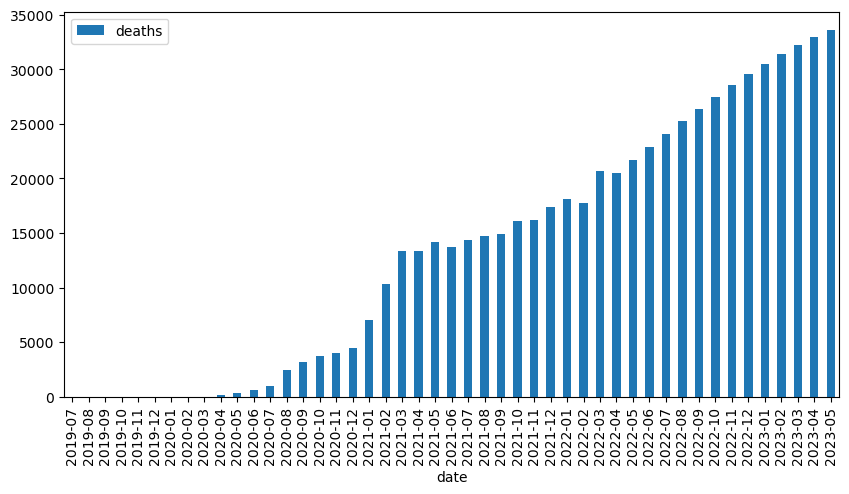

In [13]:
santa_barbara_monthly_df = get_monthly_data(covid_raw_df, '06083')
santa_barbara_monthly_imputed_df = imputation(santa_barbara_monthly_df)
santa_barbara_monthly_imputed_df.plot(x='date', y=['deaths'], kind='bar', figsize=(10, 5))
santa_barbara_monthly_imputed_df.tail()

<AxesSubplot:xlabel='date'>

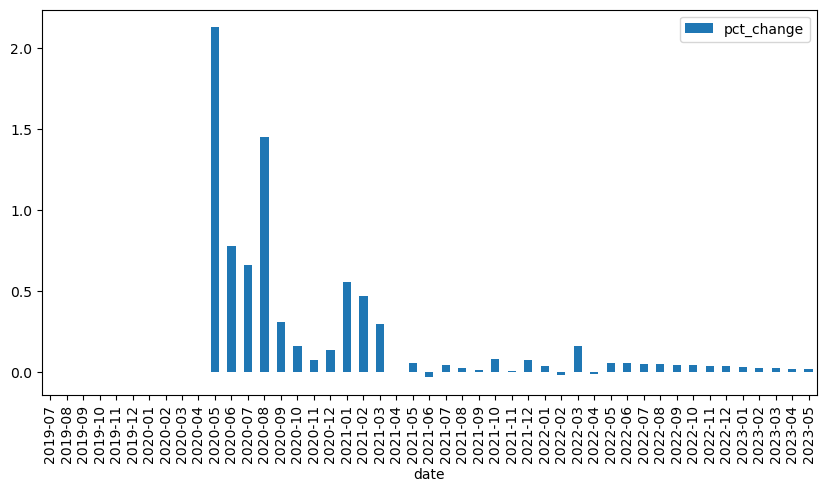

In [14]:
# plot the percent diff in santa_barbara_monthly_imputed_df
santa_barbara_monthly_imputed_df.plot(x='date', y=['pct_change'], kind='bar', figsize=(10, 5))

In [15]:
dtypes = {'cfips': str}
cfips_df = pd.read_csv('cfips.csv', dtype=dtypes)
cfips_df.head()

,cfips
0,01001
1,01003
2,01005
3,01007
4,01009


In [16]:
# dates = santa_barbara_monthly_imputed_df['date'].values
# all_data = []

# for cfips in cfips_df['cfips'].values:
#     try:
#         county_monthly_df = get_monthly_data(covid_raw_df, cfips)
#         county_monthly_imputed_df = imputation(county_monthly_df)
#         months = county_monthly_imputed_df['date'].values
#         deaths = county_monthly_imputed_df['deaths'].values
#         death_pct_diff = county_monthly_imputed_df['pct_change'].values
#         data = np.array([deaths, death_pct_diff])
#         all_data.append(data)
#     except:
#         all_data.append(-999 * np.ones((2, len(dates))))
#         print(cfips)


# There is no data for some counties

        02060
        02105
        02164
        02282
        36005
        36047
        36061
        36081
        36085

In [17]:
dtypes = {'cfips': str, 'county_name': str, 'state': str}
county_name_df = pd.read_csv('cfips_to_county_name.csv', dtype=dtypes)
county_name_df.head()

,cfips,county_name,state
0,01001,Autauga County,AL
1,01003,Baldwin County,AL
2,01005,Barbour County,AL
3,01007,Bibb County,AL
4,01009,Blount County,AL


In [18]:
# # for county 02060
# county_monthly_df = get_monthly_data(covid_raw_df, '02060')
# county_monthly_df.head()

In [19]:
missing_cfips = [
        '02060',
        '02105',
        '02164',
        '02282',
        '36005',
        '36047',
        '36061',
        '36081',
        '36085'
]

for cfips in missing_cfips:
    county_name = county_name_df[county_name_df['cfips'] == cfips]['county_name'].values[0]
    state_name = county_name_df[county_name_df['cfips'] == cfips]['state'].values[0]
    print(county_name + ', ' + state_name)

Bristol Bay Borough, AK
Hoonah-Angoon Census Area, AK
Lake and Peninsula Borough, AK
Yakutat City and Borough, AK
Bronx County, NY
Kings County, NY
New York County, NY
Queens County, NY
Richmond County, NY


# Impute missing value by similar county suggested by ChatGPT

In [20]:
missing_cfips_impute_dict = {
        '02060' : '02230',
        '02105' : '02230',
        '02164' : '02150',
        '02282' : '02230',
        '36005' : '42101',
        '36047' : '17031',
        '36061' : '06075',
        '36081' : '17031',
        '36085' : '06075',
}

In [21]:
dates = santa_barbara_monthly_imputed_df['date'].values
all_data = []

for cfips in cfips_df['cfips'].values:
    if cfips in missing_cfips:
        missing_county_name = county_name_df[county_name_df['cfips'] == cfips]['county_name'].values[0]
        missing_state_name = county_name_df[county_name_df['cfips'] == cfips]['state'].values[0]
        cfips = missing_cfips_impute_dict[cfips]
        imputed_county_name = county_name_df[county_name_df['cfips'] == cfips]['county_name'].values[0]
        imputed_state_name = county_name_df[county_name_df['cfips'] == cfips]['state'].values[0]
        print('NOTE: '+ missing_county_name + ', ' + missing_state_name + ' is imputed with ' + 
                imputed_county_name + ', ' + imputed_state_name)
    county_monthly_df = get_monthly_data(covid_raw_df, cfips)
    county_monthly_imputed_df = imputation(county_monthly_df)
    months = county_monthly_imputed_df['date'].values
    deaths = county_monthly_imputed_df['deaths'].values
    death_pct_diff = county_monthly_imputed_df['pct_change'].values
    data = np.array([deaths, death_pct_diff])
    all_data.append(data)

NOTE: Bristol Bay Borough, AK is imputed with Skagway Municipality, AK
NOTE: Hoonah-Angoon Census Area, AK is imputed with Skagway Municipality, AK
NOTE: Lake and Peninsula Borough, AK is imputed with Kodiak Island Borough, AK
NOTE: Yakutat City and Borough, AK is imputed with Skagway Municipality, AK
NOTE: Bronx County, NY is imputed with Philadelphia County, PA
NOTE: Kings County, NY is imputed with Cook County, IL
NOTE: New York County, NY is imputed with San Francisco County, CA
NOTE: Queens County, NY is imputed with Cook County, IL
NOTE: Richmond County, NY is imputed with San Francisco County, CA


In [22]:
len(all_data)

3142

In [23]:
# make sure all data has the same shape
shape_lst = []
for data in all_data:
    shape_lst.append(data.shape)

# show all unique shapes
set(shape_lst)

{(2, 47)}

In [24]:
# turn all_data into a numpy array
all_data = np.array(all_data)

all_data.shape

(3142, 2, 47)

In [25]:
dates

array(['2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
       '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
       '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
       '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
       '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06',
       '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12',
       '2023-01', '2023-02', '2023-03', '2023-04', '2023-05'],
      dtype=object)

In [32]:
# save dates
np.save('dates.npy', dates)

In [26]:
# switch dimension 2 and 0
new_data = np.swapaxes(all_data, 0, 2)
new_data.shape

(47, 2, 3142)

In [27]:
feature_names = ['deaths', 'death_pct_diff']

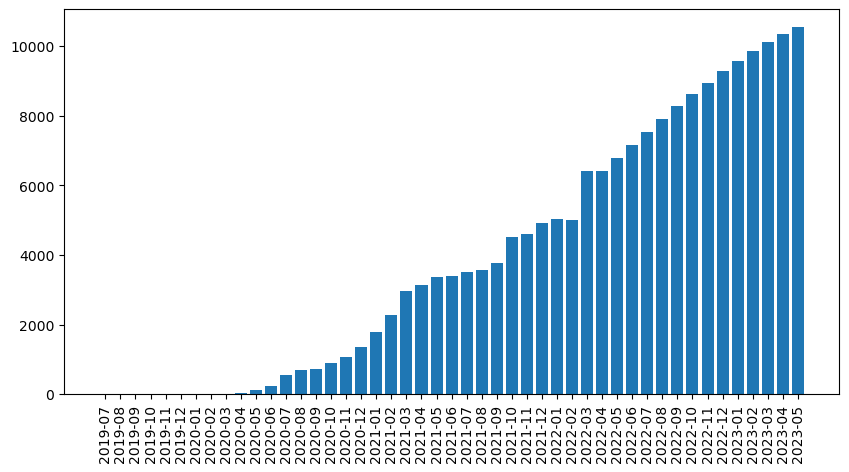

In [28]:
# plot the deaths Autauga, Alabama
death = new_data[:,0,0]

plt.figure(figsize=(10, 5))
plt.bar(dates, death)
plt.xticks(rotation=90)
plt.show()

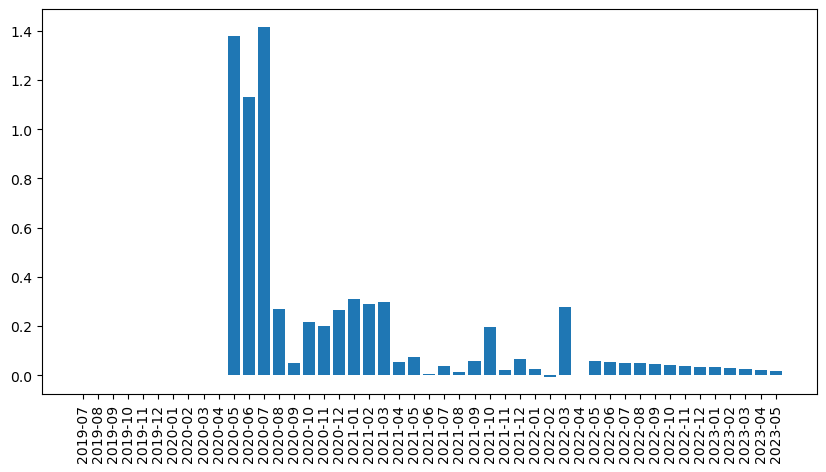

In [29]:
# plot the deaths rate diff in Autauga, Alabama
death_rate_diff = new_data[:,1,0]

plt.figure(figsize=(10, 5))
plt.bar(dates, death_rate_diff)
plt.xticks(rotation=90)
plt.show()

In [30]:
import pickle
import json

In [31]:
data_description = {'feature_0': 'deaths_number', 'feature_1': 'death_pct_diff'}

# save the data in pickle format
with open('BLOCKED_covid_monthly_data.pkl', 'wb') as f:
    pickle.dump(new_data, f)

# save the data description in json format
with open('BLOCKED_covid_monthly_data_description.json', 'w') as f:
    json.dump(data_description, f)